In [467]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_trattati.csv' # cleaned data
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_with_context.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])
df['datadate'] = df['datadate'] + pd.offsets.QuarterEnd(0)
df['divyield_Median'] = df['divyield_Median'].replace('%', '', regex=True).astype(float)

# Define columns to keep
keep_cols = ['datadate','tic', 'FFI10_desc', 'relative_quarterly_return']

df = df[keep_cols]

# Drop rows with missing values
df = df.dropna()

# Display dataframe info
df.head()

,datadate,tic,FFI10_desc,relative_quarterly_return
0,1970-03-31,F,DURBL,0.138857
1,1970-03-31,COP,ENRGY,-0.004692
2,1970-03-31,XOM,ENRGY,-0.046479
3,1970-03-31,CVX,ENRGY,-0.103189
4,1970-03-31,OXY,ENRGY,-0.071040


In [468]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import random
from contextualized.easy import ContextualizedRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters
num_stocks = 100
num_industries = 10
embedding_dim = 4
epochs = 500
lr = 0.01
reg_strength = 0.2  # weight for clustering loss

# Dummy stock-to-industry mapping (e.g. stocks 0–9 → industry 0, etc.)
stock_to_industry = torch.tensor([i // 10 for i in range(num_stocks)])

# Dummy prediction targets (e.g. simulate returns or labels)
# Just for training purposes — replace with real data
true_targets = torch.randn(num_stocks, 1)  # regression target per stock

# Dataset (each sample is one stock)
stock_ids = torch.arange(num_stocks)
industry_ids = stock_to_industry

# Model
class StockEmbedder(nn.Module):
    def __init__(self, num_stocks, num_industries, embedding_dim):
        super().__init__()
        self.stock_embedding = nn.Embedding(num_stocks, embedding_dim)
        self.industry_embedding = nn.Embedding(num_industries, embedding_dim)
        self.predictor = nn.Linear(embedding_dim, 1)  # Dummy prediction head
    
    def forward(self, stock_ids, industry_ids):
        stock_vecs = self.stock_embedding(stock_ids)         # [N, 4]
        industry_vecs = self.industry_embedding(industry_ids)  # [N, 4]
        preds = self.predictor(stock_vecs)  # dummy prediction task
        return stock_vecs, industry_vecs, preds

# Instantiate
embedder = StockEmbedder(num_stocks, num_industries, embedding_dim)
optimizer = optim.Adam(embedder.parameters(), lr=lr)
mse = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    embedder.train()
    optimizer.zero_grad()

    stock_vecs, industry_vecs, preds = embedder(stock_ids, industry_ids)
    
    # Dummy regression loss
    prediction_loss = mse(preds, true_targets)

    # Clustering loss: encourage each stock embedding to stay close to its industry
    clustering_loss = mse(stock_vecs, industry_vecs)

    # Total loss
    loss = prediction_loss + reg_strength * clustering_loss
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {loss.item():.4f}")


Epoch 50/500, Total Loss: 0.7406
Epoch 100/500, Total Loss: 0.2244
Epoch 150/500, Total Loss: 0.1015
Epoch 200/500, Total Loss: 0.0659
Epoch 250/500, Total Loss: 0.0461
Epoch 300/500, Total Loss: 0.0338
Epoch 350/500, Total Loss: 0.0259
Epoch 400/500, Total Loss: 0.0207
Epoch 450/500, Total Loss: 0.0171
Epoch 500/500, Total Loss: 0.0146


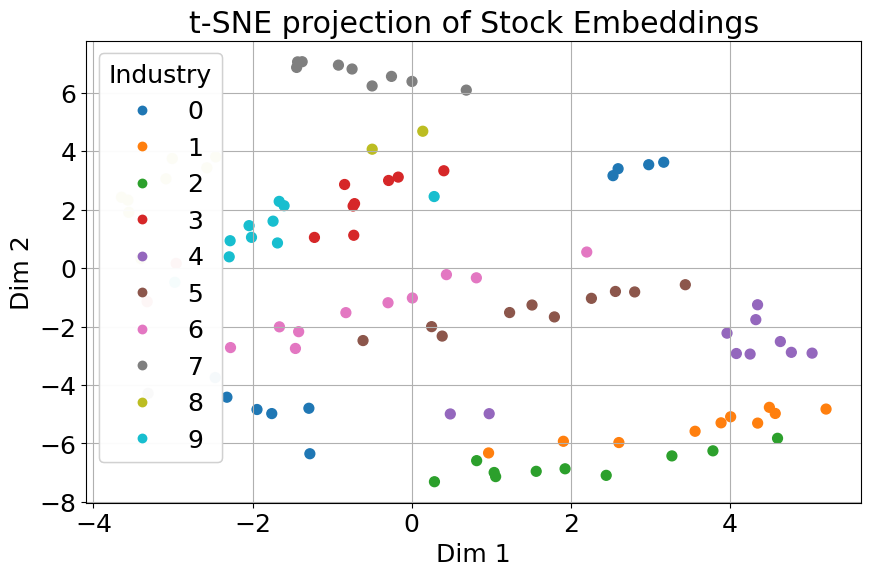

In [469]:
# ---- Visualize embeddings using t-SNE ----
embedder.eval()
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # [100, 4]
    industry_colors = stock_to_industry.numpy()

    # Reduce to 2D using t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    stock_2d = tsne.fit_transform(stock_embeddings)

    # Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(stock_2d[:, 0], stock_2d[:, 1], c=industry_colors, cmap='tab10', s=50)
    plt.title("t-SNE projection of Stock Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    legend1 = plt.legend(*scatter.legend_elements(), title="Industry")
    plt.gca().add_artist(legend1)
    plt.grid(True)
    plt.show()

In [470]:
import pandas as pd
import torch

# Simulation parameters
n_stocks = 100
n_quarters = 20
embedding_dim = 4  # must match your model

# Define stock IDs and quarters
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_quarters))  # Q0, Q1, ..., Q19

# Create full panel (stock x quarter)
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Simulate predictors
df["div_yield_change"] = np.random.normal(0, 0.1, len(df))
df["ptb_change"] = np.random.normal(0, 0.1, len(df))

# Simulate Homogenous (Effects from predictors which do not depend on context)
hom_slope = 0.2

# Simulate Homogenous context predictors (Effects directly from context which do not depend on predictors)
stock_effects = {stock: np.random.normal(0, 0.1) for stock in stocks}
time_effects = {q: np.random.normal(0, 0.1) for q in quarters}

# Simulate Heterogenous predictor (Effects from predictors which are modulated by context)
stock_slopes = {stock: 0.5 + 0.3 * np.random.rand() for stock in stocks}

df["return"] = (
    df.apply(lambda row: stock_slopes[row["stock_id"]] * row["div_yield_change"], axis=1)
    + hom_slope * df["ptb_change"]
    + df["stock_id"].map(stock_effects)
    + df["quarter"].map(time_effects)
    + np.random.normal(0, 0.05, len(df))
)

df.head()


,stock_id,quarter,div_yield_change,ptb_change,return
0,Stock_0,0,0.049671,-0.067518,-0.213552
1,Stock_0,1,-0.013826,-0.014452,-0.207012
2,Stock_0,2,0.064769,-0.079242,0.097769
3,Stock_0,3,0.152303,-0.030796,-0.052194
4,Stock_0,4,-0.023415,-0.189361,-0.187846


In [471]:
import pandas as pd
import numpy as np
import torch

# Simulation parameters
n_stocks = 100
n_quarters = 20
embedding_dim = 4  # must match your model

# Define stock IDs and quarters
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_quarters))  # Q0, Q1, ..., Q19

# Assign each stock to an industry (10 industries)
industries = {stock: i // 10 for i, stock in enumerate(stocks)}  # Stock_0–9 → 0, Stock_10–19 → 1, ..., Stock_90–99 → 9

# Create full panel (stock x quarter)
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Add industry column
df["industry"] = df["stock_id"].map(industries)

# Simulate predictors
df["div_yield_change"] = np.random.normal(0, 0.1, len(df))
df["ptb_change"] = np.random.normal(0, 0.1, len(df))

# Simulate Homogenous (Effects from predictors which do not depend on context)
hom_slope = 0.2

# Simulate Homogenous context predictors (Effects directly from context which do not depend on predictors)
stock_effects = {stock: np.random.normal(0, 0.1) for stock in stocks}
time_effects = {q: np.random.normal(0, 0.1) for q in quarters}

# Simulate Heterogenous predictor (Effects from predictors which are modulated by context)
stock_slopes = {stock: 0.5 + 0.3 * np.random.rand() for stock in stocks}

# Add explicit stock and time effect columns
df["stock_effect"] = df["stock_id"].map(stock_effects)
df["time_effect"] = df["quarter"].map(time_effects)

# Simulate returns using all components
df["return"] = (
    df["stock_effect"]
    + df["time_effect"]
    + hom_slope * df["ptb_change"]
    + df.apply(lambda row: stock_slopes[row["stock_id"]] * row["div_yield_change"], axis=1)
    #+ np.random.normal(0, 0.05, len(df))  # Optional noise
)


'''# Simulate returns
df["return"] = (
    df.apply(lambda row: stock_slopes[row["stock_id"]] * row["div_yield_change"], axis=1)
    + hom_slope * df["ptb_change"]
    + df["stock_id"].map(stock_effects)
    + df["quarter"].map(time_effects)
    #+ np.random.normal(0, 0.05, len(df))
)'''

df.head(25)


,stock_id,quarter,industry,div_yield_change,ptb_change,stock_effect,time_effect,return
0,Stock_0,0,0,-0.116207,-0.039845,-0.000061,0.023874,-0.048571
1,Stock_0,1,0,0.158212,-0.044664,-0.000061,-0.127384,-0.048678
2,Stock_0,2,0,-0.039947,0.061227,-0.000061,0.001469,-0.008489
3,Stock_0,3,0,0.012919,-0.155944,-0.000061,0.038617,0.014528
4,Stock_0,4,0,-0.006327,-0.107772,-0.000061,-0.015469,-0.040592
5,Stock_0,5,0,-0.065975,0.034316,-0.000061,0.071388,0.041619
6,Stock_0,6,0,0.098385,0.062294,-0.000061,0.009901,0.076836
7,Stock_0,7,0,0.012589,0.064154,-0.000061,-0.052241,-0.032493
8,Stock_0,8,0,-0.047655,-0.078704,-0.000061,-0.056681,-0.098899
9,Stock_0,9,0,-0.130459,-0.097827,-0.000061,0.081091,-0.010851


In [472]:
# Convert to panel format
df = df.set_index(["stock_id", "quarter"])

# Run the fixed effects model
fixed_effects_model = PanelOLS(
    dependent=df["return"],
    exog=df[["div_yield_change", "ptb_change"]],
    entity_effects=True,
    time_effects=True
)
results = fixed_effects_model.fit(cov_type="clustered", cluster_entity=True)

# Print summary
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.9815
Estimator:                   PanelOLS   R-squared (Between):              0.0457
No. Observations:                2000   R-squared (Within):               0.3699
Date:                Sat, Apr 12 2025   R-squared (Overall):              0.2235
Time:                        23:16:22   Log-likelihood                    6542.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   4.984e+04
Entities:                         100   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(2,1879)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             7783.8
                            

In [473]:
# Predictions
df["predicted_return"] = results.predict().fitted_values
df_reset = df.reset_index()

df.head()

industry  div_yield_change  ptb_change  stock_effect  \
stock_id quarter                                                         
Stock_0  0               0         -0.116207   -0.039845     -0.000061   
         1               0          0.158212   -0.044664     -0.000061   
         2               0         -0.039947    0.061227     -0.000061   
         3               0          0.012919   -0.155944     -0.000061   
         4               0         -0.006327   -0.107772     -0.000061   

                  time_effect    return  predicted_return  
stock_id quarter                                           
Stock_0  0           0.023874 -0.048571         -0.081387  
         1          -0.127384 -0.048678          0.090923  
         2           0.001469 -0.008489         -0.012916  
         3           0.038617  0.014528         -0.023190  
         4          -0.015469 -0.040592         -0.025659

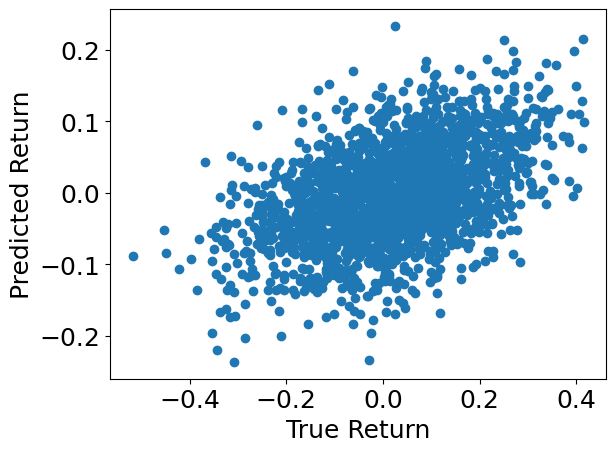

Mean-squared Error: 0.017383677893765454
Correlation: 0.20549389416216546


In [474]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(df['return'], df['predicted_return'])
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.show()

from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(df["return"], df["predicted_return"])}')
print(f'Correlation: {r2_score(df["return"], df["predicted_return"])}')

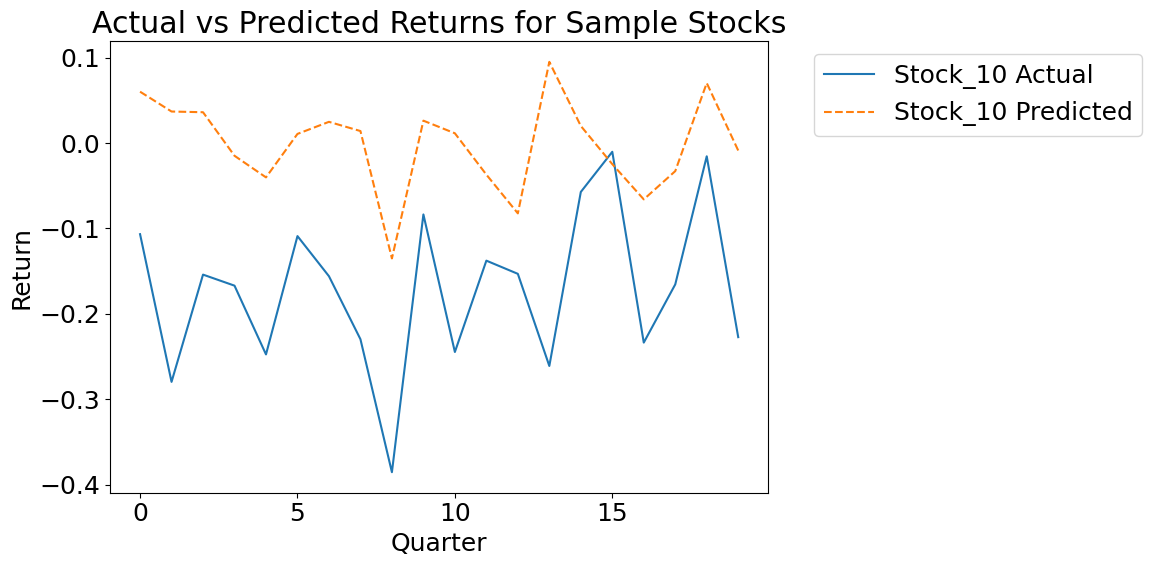

In [475]:
# Plot for first 5 stocks
fig, ax = plt.subplots(figsize=(12, 6))
sample_stocks = df_reset["stock_id"].unique()[10:11]

for stock in sample_stocks:
    stock_data = df_reset[df_reset["stock_id"] == stock]
    ax.plot(stock_data["quarter"], stock_data["return"], label=f"{stock} Actual", linestyle='-')
    ax.plot(stock_data["quarter"], stock_data["predicted_return"], label=f"{stock} Predicted", linestyle='--')

ax.set_title("Actual vs Predicted Returns for Sample Stocks")
ax.set_xlabel("Quarter")
ax.set_ylabel("Return")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [476]:
df = df.reset_index()

# ----- Get stock embeddings from the trained model -----
embedder.eval()
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # shape: [100, 4]

# Create a DataFrame mapping stock name to its embedding
embedding_df = pd.DataFrame(stock_embeddings, columns=[f"embed_dim_{i}" for i in range(embedding_dim)])
embedding_df["stock_id"] = [f"Stock_{i}" for i in range(n_stocks)]

# ----- Merge embeddings into the panel -----
df = df.merge(embedding_df, on="stock_id", how="left")

df.head()

,stock_id,quarter,industry,div_yield_change,ptb_change,stock_effect,time_effect,return,predicted_return,embed_dim_0,embed_dim_1,embed_dim_2,embed_dim_3
0,Stock_0,0,0,-0.116207,-0.039845,-0.000061,0.023874,-0.048571,-0.081387,0.028365,0.626124,-0.003805,-0.73686
1,Stock_0,1,0,0.158212,-0.044664,-0.000061,-0.127384,-0.048678,0.090923,0.028365,0.626124,-0.003805,-0.73686
2,Stock_0,2,0,-0.039947,0.061227,-0.000061,0.001469,-0.008489,-0.012916,0.028365,0.626124,-0.003805,-0.73686
3,Stock_0,3,0,0.012919,-0.155944,-0.000061,0.038617,0.014528,-0.023190,0.028365,0.626124,-0.003805,-0.73686
4,Stock_0,4,0,-0.006327,-0.107772,-0.000061,-0.015469,-0.040592,-0.025659,0.028365,0.626124,-0.003805,-0.73686


In [477]:
# Use stock_id and quarter as context
context_df = df[["embed_dim_0", "embed_dim_1", "embed_dim_2", "embed_dim_3", "quarter"]].copy()
context_df["quarter"] = context_df["quarter"].astype(int)

# Predictors
X = df[["div_yield_change", "ptb_change"]].values
Y = df["return"].values.reshape(-1, 1)
C = context_df.values  # context = (stock_id, quarter)

In [478]:
# -------------------------------
# 3. Split and normalize
# -------------------------------

C_train, C_test, X_train, X_test, Y_train, Y_test = train_test_split(C, X, Y, test_size=0.2, random_state=42)

def normalize(train, test):
    mean = train.mean(axis=0)
    std = train.std(axis=0)
    return (train - mean) / std, (test - mean) / std

'''X_train, X_test = normalize(X_train, X_test)
C_train, C_test = normalize(C_train, C_test)
Y_train, Y_test = normalize(Y_train, Y_test)'''

'X_train, X_test = normalize(X_train, X_test)\nC_train, C_test = normalize(C_train, C_test)\nY_train, Y_test = normalize(Y_train, Y_test)'

In [479]:
'''model = ContextualizedRegressor()
model.fit(C_train, X_train, Y_train,
          encoder_type="mlp",
          max_epochs=10,
          learning_rate=1e-2)'''

'model = ContextualizedRegressor()\nmodel.fit(C_train, X_train, Y_train,\n          encoder_type="mlp",\n          max_epochs=10,\n          learning_rate=1e-2)'

In [480]:
contextualized_coeffs, contextualized_offsets = model.predict_params(C_test)
Y_pred = model.predict(C_test, X_test)

from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(Y_test, Y_pred)}')
print(f'Correlation: {r2_score(Y_test, Y_pred)}')

Mean-squared Error: 0.01825974793492454
Correlation: 0.1867573273021489


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


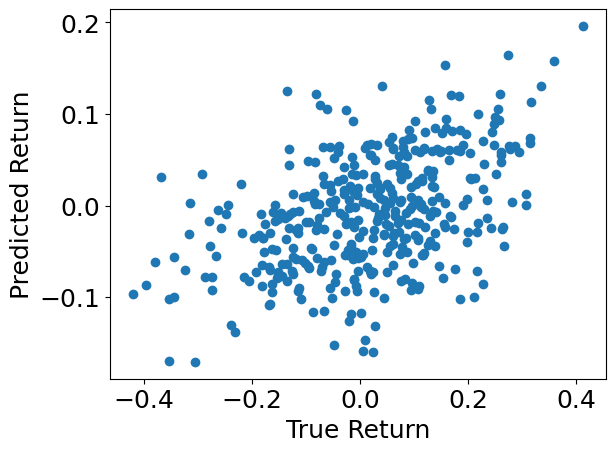

In [481]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(Y_test, Y_pred)
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.show()

In [482]:
contextualized_coeffs, contextualized_offsets = model.predict_params(C_test)
Y_pred = model.predict(C_test, X_test)

contextualized_coeffs

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


array([[[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.57029873, 0.24213196]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.57262164, 0.24143222]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56548262, 0.24358276]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402036]],

       [[0.56402993, 0.24402